In [1]:
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import transforms
from coco_dataset import COCOPanopticDataset
from pixeldecoder import PixelDecoder
from backbone import BackboneWithMultiScaleFeatures
from tokenizer import TaskTokenizer
from mlp import TaskMLP
from text_mapper import TextMapper
from contrastive_loss import ContrastiveLoss
from query_formulation import TaskConditionedQueryFormulator
from compute_loss import SetCriterion
from hungarian_matcher import HungarianMatcher
from transformer_decoder import TransformerDecoder
from predict import MaskClassPredictor
from torchmetrics import JaccardIndex
import pandas as pd

# Define hyperparameters
vocab_size = 30000
embed_dim = 256
max_seq_len = 128
num_queries = 100
temperature = 0.2
num_heads = 8
num_layers = 6
num_classes = 80
contrastive_weight = 0.5
primary_loss_weight = 1.0

# COCO Dataset Paths (Change the path if necessary)
train_image_dir = "datasets/coco/train2017"
train_instance_file = "datasets/coco/annotations/instances_train2017.json"
train_panoptic_file = "datasets/coco/annotations/panoptic_train2017.json"
train_panoptic_mask_dir = "datasets/coco/panoptic_train2017"

data_transform = transforms.Compose([
    transforms.Resize((512, 512)),
    transforms.ToTensor(),
])

# Initialize the dataset and DataLoader
full_train_dataset = COCOPanopticDataset(
    image_dir=train_image_dir,
    instance_file=train_instance_file,
    panoptic_file=train_panoptic_file,
    panoptic_mask_dir=train_panoptic_mask_dir,
    transform=data_transform
)

train_dataset = torch.utils.data.Subset(full_train_dataset, range(5000))
train_loader = DataLoader(train_dataset, batch_size=1, shuffle=False, num_workers=4)





/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
backbone = BackboneWithMultiScaleFeatures()
pixel_decoder = PixelDecoder(input_channels=[256, 512, 1024, 2048])
tokenizer = TaskTokenizer(vocab_size, embed_dim, max_seq_len)
mlp = TaskMLP(input_dim=embed_dim, hidden_dim=embed_dim, output_dim=embed_dim)
text_mapper = TextMapper(vocab_size=vocab_size, embed_dim=embed_dim)
contrastive_loss_fn = ContrastiveLoss(temperature)
task_query_formulator = TaskConditionedQueryFormulator(num_queries=num_queries, embed_dim=embed_dim)
matcher = HungarianMatcher(cost_class=1, cost_mask=1, cost_dice=1)
criterion = SetCriterion(matcher=matcher, num_classes=num_classes, weight_dict={'loss_ce': 1, 'loss_mask': 1, 'loss_dice': 1}, eos_coef=0.1, losses=['labels', 'masks'])
transformer_decoder = TransformerDecoder(
    embed_dim=embed_dim,
    num_queries=num_queries,
    num_classes=num_classes,
    num_heads=num_heads,
    num_layers=num_layers
)

mask_class_predictor = MaskClassPredictor(embed_dim, num_queries, num_classes)

optimizer = torch.optim.Adam([
    {"params": backbone.parameters()},
    {"params": pixel_decoder.parameters()},
    {"params": transformer_decoder.parameters()},
    {"params": mask_class_predictor.parameters()},
    {"params": mlp.parameters()},
    {"params": text_mapper.parameters()},
    {"params": task_query_formulator.parameters()},
], lr=1e-4)

miou_metric = JaccardIndex(task='multiclass', num_classes=num_classes)

all_pred_logits, all_pred_masks, all_gt_labels, all_gt_masks = [], [], [], []

# This is for generating graphs
epoch_list = []
contrastive_loss_list = []
cross_entropy_loss_list = []
miou_list = []

num_epochs = 10 # You can change this number, but more than 10 might take a long time.

for epoch in range(num_epochs):
    print(f"Epoch {epoch+1}/{num_epochs}")
    epoch_contrastive_loss = 0.0
    epoch_cross_entropy_loss = 0.0
    epoch_miou = 0.0

    for image_batch, mask_batch in train_loader:
        optimizer.zero_grad()

        multi_scale_features = backbone(image_batch)
        decoded_features = pixel_decoder(multi_scale_features)
        image_features_1_4 = decoded_features[0]

        task_texts = ["panoptic", "instance", "semantic"]
        task_embeddings = tokenizer.forward(task_texts)
        task_embeddings = mlp(task_embeddings.mean(dim=1).unsqueeze(1)).squeeze(1)

        q_text = text_mapper(
            panoptic_text=task_embeddings[0].unsqueeze(0).long(),
            instance_text=task_embeddings[1].unsqueeze(0).long(),
            semantic_text=task_embeddings[2].unsqueeze(0).long()
        )

        #Generate Q_task
        batch_size = image_batch.size(0)
        q_task = task_query_formulator(task_embeddings.unsqueeze(1), batch_size).permute(1, 0, 2)

        contrastive_loss = contrastive_loss_fn(q_text, q_task)
        print(f"Contrastive Loss: {contrastive_loss.item()}")

        if q_text.size(0) == 1:
            q_text = q_text.expand(q_task.size(0), -1, -1)

        q_text = F.normalize(q_text, dim=-1)
        q_task = F.normalize(q_task, dim=-1)

        batch_size, num_tasks, embed_dim = q_text.size()
        _, num_queries, _ = q_task.size()
        
        q_text = q_text.reshape(batch_size * num_tasks, embed_dim)
        q_task = q_task.reshape(batch_size * num_queries, embed_dim)

        decoder_output = transformer_decoder(q_task, multi_scale_features)

        flattened_image_features_1_4 = image_features_1_4.view(1, embed_dim, 128 * 128).permute(0, 2, 1)

        combined_input = torch.cat([decoder_output, flattened_image_features_1_4], dim=1)

        mask_pred, class_pred = mask_class_predictor(combined_input)
        
        outputs = {'pred_logits': class_pred, 'pred_masks': mask_pred}
        
        targets = [{'labels': mask_batch[0]}]
        primary_loss = criterion(outputs, targets)
        
        total_loss = contrastive_weight * contrastive_loss + primary_loss_weight * sum(primary_loss.values())
        
        total_loss.backward()
        optimizer.step()
        
        #print(f"Contrastive Loss: {contrastive_loss.item()}, Primary Loss: {sum(primary_loss.values()).item()}, Total Loss: {total_loss.item()}")

        epoch_contrastive_loss += contrastive_loss.item()
        epoch_cross_entropy_loss += primary_loss.get('loss_ce', torch.tensor(0.0)).item()

        all_pred_logits.append(class_pred)
        all_pred_masks.append(mask_pred)
        all_gt_labels.append(mask_batch[0])
        all_gt_masks.append(mask_batch[0])

        mask_pred_resized = F.interpolate(mask_pred, size=(512, 512), mode="nearest")
        mask_pred_classes = mask_pred_resized.argmax(dim=1)

        mask_pred_classes = mask_pred_classes.squeeze(0).long()
        mask_batch_labels = mask_batch[0].long()

        mask_batch_labels = mask_batch_labels.clone()
        mask_batch_labels[(mask_batch_labels >= num_classes) | (mask_batch_labels < 0)] = -1

        mask_pred_classes = mask_pred_classes.to(mask_batch_labels.device)
        #mask_pred_classes[(mask_pred_classes >= num_classes) | (mask_pred_classes < 0)] = -1
        mask_pred_classes = mask_pred_classes.clamp(0, num_classes - 1)
        mask_batch_labels = mask_batch_labels.clamp(0, num_classes - 1)
        
        mask_pred_classes = mask_pred_classes.view(-1)
        mask_batch_labels = mask_batch_labels.view(-1)

        mask_pred_classes[mask_pred_classes < 0] = -1
        mask_batch_labels[mask_batch_labels < 0] = -1

        miou_metric.update(mask_pred_classes, mask_batch_labels)

        break

    epoch_miou = miou_metric.compute().item()
    miou_metric.reset()

    epoch_list.append(epoch + 1)
    contrastive_loss_list.append(epoch_contrastive_loss)
    cross_entropy_loss_list.append(epoch_cross_entropy_loss)
    miou_list.append(epoch_miou)

    print(f"Epoch {epoch+1} - Contrastive Loss: {epoch_contrastive_loss}, Cross-Entropy Loss: {epoch_cross_entropy_loss}, mIoU: {epoch_miou}")

Epoch 1/10
Contrastive Loss: 5.8376078605651855
Cross-entropy loss: 0.0
Epoch 1 - Contrastive Loss: 5.8376078605651855, Cross-Entropy Loss: 0.0, mIoU: 9.5367431640625e-06
Epoch 2/10
Contrastive Loss: 5.774187088012695
Cross-entropy loss: 0.0
Epoch 2 - Contrastive Loss: 5.774187088012695, Cross-Entropy Loss: 0.0, mIoU: 9.5367431640625e-06
Epoch 3/10
Contrastive Loss: 5.71146821975708
Cross-entropy loss: 0.0
Epoch 3 - Contrastive Loss: 5.71146821975708, Cross-Entropy Loss: 0.0, mIoU: 9.5367431640625e-06
Epoch 4/10
Contrastive Loss: 5.649392604827881
Cross-entropy loss: 0.0
Epoch 4 - Contrastive Loss: 5.649392604827881, Cross-Entropy Loss: 0.0, mIoU: 9.5367431640625e-06
Epoch 5/10
Contrastive Loss: 5.58760929107666
Cross-entropy loss: 0.0
Epoch 5 - Contrastive Loss: 5.58760929107666, Cross-Entropy Loss: 0.0, mIoU: 9.5367431640625e-06
Epoch 6/10
Contrastive Loss: 5.526155948638916
Cross-entropy loss: 0.0
Epoch 6 - Contrastive Loss: 5.526155948638916, Cross-Entropy Loss: 0.0, mIoU: 9.536743

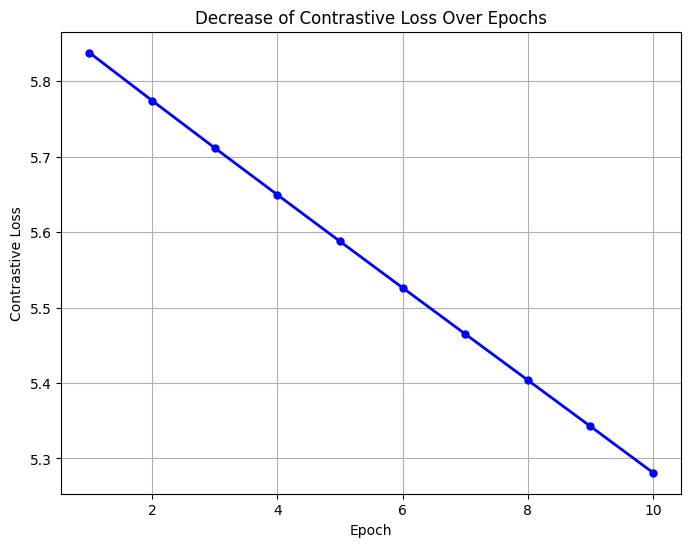

In [ ]:
import matplotlib.pyplot as plt

epochs = list(range(1, 11))

plt.figure(figsize=(8, 6))
plt.plot(epochs, contrastive_loss_list, marker='o', color='b', linestyle='-', linewidth=2, markersize=5)
plt.xlabel('Epoch')
plt.ylabel('Contrastive Loss')
plt.title('Decrease of Contrastive Loss Over Epochs')
plt.grid(True)

plt.savefig('contrastive_loss_over_epochs.png', dpi=300)
plt.show()

In [ ]:
metrics_df = pd.DataFrame({
    "Epoch": epoch_list,
    "Contrastive Loss": contrastive_loss_list,
    "Cross-Entropy Loss": cross_entropy_loss_list,
    "mIoU": miou_list
})

metrics_df.to_csv("training_metrics.csv", index=False)
print("Metrics saved to training_metrics.csv")

print(metrics_df)

Metrics saved to training_metrics.csv
   Epoch  Contrastive Loss  Cross-Entropy Loss     mIoU
0      1          5.837608                 0.0  0.00001
1      2          5.774187                 0.0  0.00001
2      3          5.711468                 0.0  0.00001
3      4          5.649393                 0.0  0.00001
4      5          5.587609                 0.0  0.00001
5      6          5.526156                 0.0  0.00001
6      7          5.464902                 0.0  0.00001
7      8          5.403699                 0.0  0.00001
8      9          5.342478                 0.0  0.00001
9     10          5.281090                 0.0  0.00001
